In [55]:
using ZipFile, Distributed, CSV, DataFrames, Random, StatsBase, Plots, Statistics, StableRNGs, MLJBase
using Flux
using Flux: logitbinarycrossentropy
using BSON: @save
using Distributions

file = CSV.read("train.csv", DataFrame)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep
,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Float64
1,842,0,2.2,0,1,0,7,0.6
2,1021,1,0.5,1,0,1,53,0.7
3,563,1,0.5,1,2,1,41,0.9
4,615,1,2.5,0,0,0,10,0.8
5,1821,1,1.2,0,13,1,44,0.6
6,1859,0,0.5,1,3,0,22,0.7
7,1821,0,1.7,0,4,1,10,0.8
8,1954,0,0.5,1,0,0,24,0.8
9,1445,1,0.5,0,0,0,53,0.7


In [56]:
# Transfer DataFrame to matrix form
df = file |> Tables.matrix

# Transfer the dataset to 2-classifiers. df_0 represents the result is 0, df_1 represents the result is 1.
# Due to my datasset is binary problems, and each result is 50 percents of the whole dataset. So i didn't add any other pre-actions for dataset. 

mat_0 = df[df[:,21] .<= 1, :]
mat_1 = df[df[:,21] .>= 2, :]


1000×21 Matrix{Float64}:
 1021.0  1.0  0.5  1.0   0.0  1.0  53.0  …   3.0   7.0  1.0  1.0  0.0  2.0
  563.0  1.0  0.5  1.0   2.0  1.0  41.0      2.0   9.0  1.0  1.0  0.0  2.0
  615.0  1.0  2.5  0.0   0.0  0.0  10.0      8.0  11.0  1.0  0.0  0.0  2.0
 1821.0  0.0  1.7  0.0   4.0  1.0  10.0      8.0  18.0  1.0  0.0  1.0  3.0
  769.0  1.0  2.9  1.0   0.0  0.0   9.0      2.0   7.0  0.0  0.0  0.0  3.0
 1520.0  1.0  2.2  0.0   5.0  1.0  33.0  …   9.0  13.0  1.0  1.0  1.0  3.0
  803.0  1.0  2.1  0.0   7.0  0.0  17.0      1.0   4.0  1.0  0.0  1.0  2.0
  838.0  0.0  0.5  0.0   1.0  1.0  13.0      9.0  19.0  1.0  0.0  1.0  3.0
  595.0  0.0  0.9  1.0   7.0  1.0  23.0      2.0  18.0  1.0  1.0  0.0  3.0
  772.0  0.0  1.1  1.0  12.0  0.0  39.0     15.0   3.0  1.0  1.0  0.0  3.0
    ⋮                         ⋮          ⋱   ⋮                         ⋮
 1784.0  0.0  1.6  0.0   4.0  0.0  41.0      1.0  11.0  0.0  1.0  0.0  2.0
 1262.0  0.0  1.8  1.0  12.0  0.0  34.0      3.0   4.0  0.0  1.0  1.0  2.0
 1

In [57]:
# randomly select 70% data from data set as the train data

train_data = randsubseq(1:1000, 0.7)
train_df = vcat(mat_0[train_data, :], mat_1[train_data, :])

# select the rest as the test data 

test_data = [i for i in 1:1000 if isempty(searchsorted(train_data, i))]
test_df = vcat(mat_0[test_data, :], mat_1[test_data, :])

554×21 Matrix{Float64}:
  842.0  0.0  2.2  0.0  1.0  0.0   7.0  …   7.0  19.0  0.0  0.0  1.0  1.0
 1815.0  0.0  2.8  0.0  2.0  0.0  33.0      0.0   2.0  1.0  0.0  0.0  1.0
  682.0  1.0  0.5  0.0  4.0  0.0  19.0      1.0  18.0  0.0  1.0  1.0  1.0
 1949.0  0.0  2.6  1.0  4.0  0.0  47.0      5.0  20.0  0.0  0.0  1.0  1.0
  851.0  0.0  0.5  0.0  3.0  0.0  21.0      7.0  10.0  1.0  0.0  1.0  0.0
 1319.0  1.0  0.9  0.0  3.0  1.0  41.0  …   5.0   3.0  1.0  1.0  1.0  1.0
 1757.0  0.0  0.5  0.0  8.0  0.0  49.0      5.0   4.0  0.0  0.0  0.0  1.0
 1156.0  1.0  1.2  1.0  0.0  1.0  50.0      0.0  15.0  1.0  1.0  0.0  0.0
  797.0  1.0  2.9  1.0  4.0  0.0  38.0      2.0   6.0  0.0  1.0  0.0  0.0
  543.0  0.0  0.5  0.0  0.0  0.0  57.0     14.0  15.0  1.0  0.0  0.0  1.0
    ⋮                        ⋮          ⋱   ⋮                         ⋮
  689.0  0.0  1.4  0.0  2.0  0.0  45.0  …   1.0  10.0  1.0  0.0  0.0  3.0
  591.0  1.0  0.5  1.0  1.0  1.0  16.0      0.0   5.0  1.0  1.0  0.0  3.0
 1602.0  0.0  1.

In [58]:
# parameters of the training and testing data
para_train = train_df[:, 1:20]
para_test = test_df[:, 1:20]

# value is never used?
value_train = train_df[:, 21]
value_test = test_df[:, 21]
value_train_std = reshape(value_train, (1, :)) 
value_test_std = reshape(value_test, (1, :)) 


1×554 Matrix{Float64}:
 1.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  …  2.0  3.0  3.0  3.0  3.0  2.0  3.0

In [59]:
dt = StatsBase.fit(ZScoreTransform, para_train, dims=1)

# rotate the matrix for 90 degree
para_train_std = StatsBase.transform(dt, para_train)
para_test_std = StatsBase.transform(dt, para_test)

para_train_std = transpose(para_train_std) 
para_test_std = transpose(para_test_std)

20×554 transpose(::Matrix{Float64}) with eltype Float64:
 -0.892347   1.32205    -1.25648    …  -0.951519   1.66343     1.54054
 -0.984559  -0.984559    1.01498       -0.984559   1.01498    -0.984559
  0.83099    1.56622    -1.25216        1.8113     1.32114    -0.762009
 -1.01498   -1.01498    -1.01498        0.984559   0.984559    0.984559
 -0.768758  -0.539746   -0.0817222     -0.539746  -0.997771   -0.768758
 -1.0669    -1.0669     -1.0669     …  -1.0669    -1.0669      0.936651
 -1.39053    0.0355419  -0.732346      -1.28084    0.364637    0.200089
  0.342352   0.342352    1.72902       -1.39099   -1.04432     0.68902
  1.35629    0.531265   -0.549798      -0.663594   1.32784    -0.919635
 -1.08842   -0.212596   -0.212596      -1.52633   -0.212596    1.53905
 -1.34531    1.17388     0.166203   …  -1.17736   -1.17736    -1.17736
 -1.40889   -0.0871988   0.577022       1.23899    0.606293    0.500468
 -1.15563   -1.17407    -0.4456         0.907606   1.63147     0.863805
  0.387503 

In [60]:
# basic parameters
batch_size = 20
population_size = 300
Mutation_rate = 0.5
Crossover_rate = 0.4
Retain_rate = 0.9
iteration = 500
layer = 2

2

In [61]:
#build the models with sigmoid as Activation Function

function sigmoidModel(batch_size)
    # model = Chain(Dense(batch_size, 12, relu), Dense(12, 1, relu))
    # now we have 5 layers(3-hidden layers) instead of 2 in original
   model=Chain(Dense(batch_size, 18, relu),Dense(18, 16, relu),Dense(16, 12, relu),Dense(12, 8, relu), Dense(8, 1, relu))
    return model
end

sigmoidModel (generic function with 1 method)

In [62]:
# We will define a function that can generate initial weight and bias for the neutral network.

function generateInitialPopulation(initial_population_size)
    chromosomes = []
    for i in 1 : initial_population_size
        chromosome = sigmoidModel(batch_size)
        push!(chromosomes, chromosome)
    end
    return chromosomes
end

generateInitialPopulation (generic function with 1 method)

In [63]:
# Do we need to train the network?


function trainNetwork(chromosomes)
    model_mean_acc_list = []
    i=1

    for model in chromosomes
        push!(model_mean_acc_list, mean(accuracy(para_train_std, value_train_std, i)))
        i = i + 1
    end
    
    index = reverse(sortperm(model_mean_acc_list))
    model_mean_acc_list = model_mean_acc_list[index]
    chromosome = chromosomes[index]
    
    return chromosome, model_mean_acc_list
end

trainNetwork (generic function with 1 method)

In [64]:
# why there is no manipuation on test data?
function testModel(model_index)
    model_acc_list=[]
    return mean(accuracy(para_test_std, value_test_std, model_index))
end

testModel (generic function with 1 method)

In [65]:
# create a new model using two parent models

function crossover(parent_one_chromosome,parent_two_chromosome)
    n_offspring = deepcopy(parent_one_chromosome)
    for i in 1:layer
        select_one_layer = shuffle(collect(1:layer))[1]
        mother_bias=parent_two_chromosome[select_one_layer].bias
        row_to_shuffle = shuffle(collect(1:size(mother_bias)[1]))[1]
        if rand() < Crossover_rate
            n_offspring[select_one_layer].bias[row_to_shuffle]=mother_bias[row_to_shuffle]
        end
    end
    
    for i in 1:layer
        select_one_layer=shuffle(collect(1:layer))[1]
        mother_weight=parent_two_chromosome[select_one_layer].weight
        row_to_shuffle=shuffle(collect(1:size(mother_weight)[1]))[1]
        col_to_shuffle=shuffle(collect(1:size(mother_weight)[2]))[1]
        if rand() < Crossover_rate
            n_offspring[select_one_layer].weight[row_to_shuffle,col_to_shuffle]=mother_weight[row_to_shuffle,col_to_shuffle]
        end
    end
    return n_offspring
end

crossover (generic function with 1 method)

In [66]:
#Do mutation here
function mutation(offspring)
    n_offspring = deepcopy(offspring)
    for i in 1:layer
        select_one_layer = shuffle(collect(1:layer))[1]
        bias = offspring[select_one_layer].bias
        row_to_shuffle = shuffle(collect(1:size(bias)[1]))[1]
        if rand() < Mutation_rate
            n_offspring[select_one_layer].bias[row_to_shuffle] += rand(Uniform(-0.5,0.5),1)[1]
        end
    end
    
    for i in 1:layer
        select_one_layer = shuffle(collect(1:layer))[1]
        weight = n_offspring[select_one_layer].weight
        row_to_shuffle = shuffle(collect(1:size(weight)[1]))[1]
        col_to_shuffle = shuffle(collect(1:size(weight)[2]))[1]
        if rand() < Mutation_rate
            n_offspring[select_one_layer].weight[row_to_shuffle,col_to_shuffle] += rand(Uniform(-0.5,0.5),1)[1]
        end
    end
    return n_offspring
end

mutation (generic function with 1 method)

In [67]:
chromosomes = generateInitialPopulation(population_size)

300-element Vector{Any}:
 Chain(Dense(20, 18, relu), Dense(18, 16, relu), Dense(16, 12, relu), Dense(12, 8, relu), Dense(8, 1, relu))  # 999 parameters
 Chain(Dense(20, 18, relu), Dense(18, 16, relu), Dense(16, 12, relu), Dense(12, 8, relu), Dense(8, 1, relu))  # 999 parameters
 Chain(Dense(20, 18, relu), Dense(18, 16, relu), Dense(16, 12, relu), Dense(12, 8, relu), Dense(8, 1, relu))  # 999 parameters
 Chain(Dense(20, 18, relu), Dense(18, 16, relu), Dense(16, 12, relu), Dense(12, 8, relu), Dense(8, 1, relu))  # 999 parameters
 Chain(Dense(20, 18, relu), Dense(18, 16, relu), Dense(16, 12, relu), Dense(12, 8, relu), Dense(8, 1, relu))  # 999 parameters
 Chain(Dense(20, 18, relu), Dense(18, 16, relu), Dense(16, 12, relu), Dense(12, 8, relu), Dense(8, 1, relu))  # 999 parameters
 Chain(Dense(20, 18, relu), Dense(18, 16, relu), Dense(16, 12, relu), Dense(12, 8, relu), Dense(8, 1, relu))  # 999 parameters
 Chain(Dense(20, 18, relu), Dense(18, 16, relu), Dense(16, 12, relu), Dense(12, 8, rel

In [68]:
train_acc_list = []
test_acc_list = []

Any[]

In [69]:

# println("\nTrial") 
accuracy(para, val, i) = mean(vec(chromosomes[i](para) .> 0.5) .== val)

model,score = trainNetwork(chromosomes)
# println("\nTrial") 
#erase models with low accuracy
# println(typeof(size(chromosomes)[1] * Retain_rate)) 
# println(typeof())
chromosomes = chromosomes[1 : floor(Int ,size(chromosomes)[1] * Retain_rate)]
# println("\nTrial") 
test_acc=testModel(1)
# println("\nTrial") 
append!(train_acc_list,mean(score))
append!(test_acc_list,test_acc)

# println("\nTrial") 

for i in 1 : 7
    println(accuracy(para_train_std, value_train_std, i))
end

while size(chromosomes)[1] < population_size
    # select a chromosome to do crossover
    model_mean_acc_list = []
    i=1
    for chromosome in chromosomes
        append!(model_mean_acc_list,mean(accuracy(para_train_std,value_train_std,i)))
        i=i+1
    end

    idx=collect(1:size(chromosomes)[1])
    idx=shuffle(idx)
    parent_one_chromosome=chromosomes[idx[1]]
    parent_two_chromosome=chromosomes[idx[2]]

    offspring = crossover(parent_one_chromosome,parent_two_chromosome)
    offspring = mutation(offspring)
    append!(chromosomes,[offspring])
end
println("new")
for j in 1:7
    println(accuracy(para_train_std, value_train_std,j))
end 

0.24709074874361284
0.2469697491434376
0.2462069255771155
0.2470960095957944
0.24619640387275243
0.24619640387275243
0.2503787813570703


new
0.24709074874361284
0.2469697491434376
0.2462069255771155
0.2470960095957944
0.24619640387275243
0.24619640387275243
0.2503787813570703


In [70]:
# to do the test
test=[]

for j in 1:30
    push!(test,accuracy(para_train_std, value_train_std,j))
end

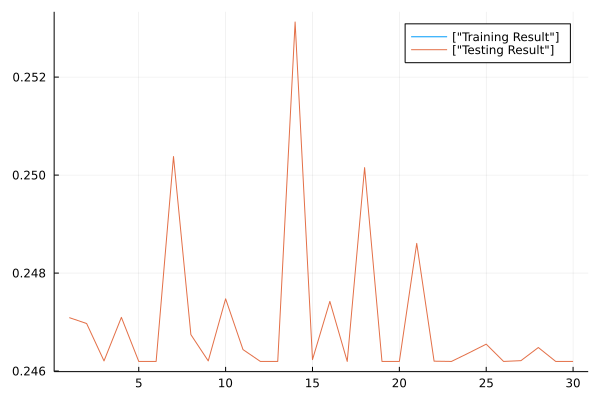

In [71]:
Plots.plot(train_acc_list,label=["Training Result"])
Plots.plot!(test,label=["Testing Result"])

In [72]:
"""
    In order to compute for confusion matrix
"""
#TT
TT = sum(vec(chromosomes[1](para_test_std) .> 0.5) .== 1)
#TF
TF = sum(vec(chromosomes[1](para_test_std) .> 0.5) .== 0)
#FT
FT = sum(vec(chromosomes[1](para_test_std) .< 0.5) .== 1)
#FF
FF = sum(vec(chromosomes[1](para_test_std) .< 0.5) .== 0)
println("confusion matrix:")
println("True True Result: $TT,  True False Result: $TF")
println("False False Result: $FF,   False True Result: FT")

confusion matrix:
True True Result: 76,  True False Result: 478
False False Result: 76,   False True Result: FT
